In [1]:
from __future__ import division
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from DEICODE import untangle, fetch, optimize_impute
#transforms 
from skbio.stats.composition import clr, ilr, centralize
#else
%matplotlib inline
# make the notebook readable
from IPython.core.display import HTML
HTML("""<style>div.cell { /* Tunes the space between cells */margin-top:1em;margin-bottom:1em;}div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 3em;line-height:1.4em;text-align:center;}
div.text_cell_render h2 { /*  Parts names nearer from text */margin-bottom: -0.4em;}
div.text_cell_render { /* Customize text cells */font-family: 'Times New Roman';font-size:1.2em;line-height:1.4em;
padding-left:3em;padding-right:3em;}</style>""")

 Infant (case study)


 The colonization process of the infant gut microbiome has been called chaotic, but this view could reflect insufficient documentation of the factors affecting the microbiome. We performed a 2.5-year case study of the assembly of the human infant gut microbiome to relate life events to microbiome composition and function. Sixty fecal samples were collected from a healthy infant along with a diary of diet and health status.
 
 P.I.  Ruth Ley (Cornell University)
 [Data and Source](https://qiita.ucsd.edu/study/description/101#)

First we import the .biom OTU table and tab delimited mapping file (Qiime style) as pandas data frames. 

 Both of these datasets can be easily produced from your own 16S rRNA gene amplicon sequencing results using [Qiime2](https://qiime2.org)

In [2]:
map_file='data/benchmarking/infant_time_series_map.txt' #import metadata
in_biom='data/benchmarking/infant_time_series.biom' #import biom file
otutabledf,mappingdf,taxnames=fetch.dfimport(in_biom,map_file)
mappingdf.drop('Color Description',axis=0,inplace=True)
mappingdf=mappingdf.astype(str)

Next we will run supervised machine learning this will help us identify biologically relevant trends in the data quickly

In [3]:
# This command will do machine leanring on your otu table and mapping file. It ouputs your scores

# The main input is just the otu table and the mapping data. 

# complete will determine if you do completion (iteration is the number of iterations for the completion)

infantscores,infant_low_rank_data=untangle.machine_learning(otutabledf,mappingdf.T,complete=True,iteration=300,mean_count=5)

 Now we can visualize the output of the machine learning.

 The cross-validation scores give you a metric of how well each mapping category (i.e. metadata column) correlates to the taxonomic patterns in your data. Here we see that 4 metadata categories (solid-food, formula, breastmilk, and color description) correlate perfectly with the taxonomic trends.  

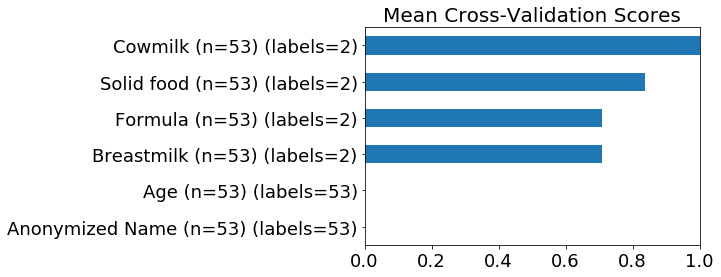

In [4]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1)
infantscores.columns=['Matrix Completion (RF)']
infantscores.sort_values(['Matrix Completion (RF)'], ascending = [True], inplace = True)
#rename a few
infantscores.plot(kind='barh',fontsize=18,xlim=(0,1),legend=False,ax=ax1)
ax1.set_ylabel('')
plt.title('Mean Cross-Validation Scores',fontsize=20)
plt.show()



To view how much better we can predict using matrix completion we can look and the confusion matrix for our best prediction, breast milk. The accuracy measure is in the diagonal values, the closer it is to 1 the better (1 is the max).

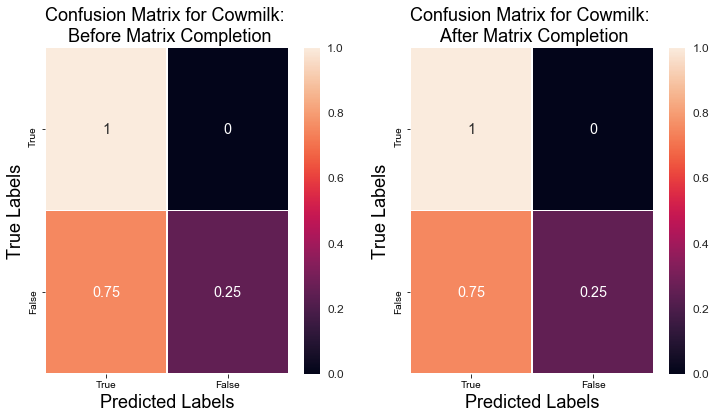

In [5]:
#get confusion matrix
niche='Cowmilk' #this is a mapping file catagory you would like to plot
orgconfuse=untangle.get_confusion(otutabledf,mappingdf.T[~mappingdf.T[niche].isin(['Unknown','Not applicable'])],niche,0.4)
lrconfuse=untangle.get_confusion(infant_low_rank_data,mappingdf.T[~mappingdf.T[niche].isin(['Unknown','Not applicable'])],niche,0.4)         

#plot
fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 6)) 
fntsizes=18
sns.set(font_scale=1.2)
sns.heatmap(orgconfuse, annot=True, linewidths=.5,ax=ax1)
ax1.set_title('Confusion Matrix for Cowmilk: \n Before Matrix Completion',fontsize=fntsizes)
ax1.set_ylabel('True Labels',fontsize=fntsizes)
ax1.set_xlabel('Predicted Labels',fontsize=fntsizes)   
sns.heatmap(lrconfuse, annot=True, linewidths=.5,ax=ax2)
ax2.set_title('Confusion Matrix for Cowmilk: \n After Matrix Completion',fontsize=fntsizes)
ax2.set_ylabel('True Labels',fontsize=fntsizes)
ax2.set_xlabel('Predicted Labels',fontsize=fntsizes)
plt.show()

As we can see we do indeed learn better after we complete the OTU table. 


Now we want to extract OTUs (features) that separate the infant fed solid food versus breastmilk alone.

 Now that we know cowsmilk is an important category we would like to find out what pattern of OTUs best explain this variation. Here we plot the taxonomic pattern that the machine learning algorithm found to be most predictive for the infant drinking cowsmilk (True) versus those time when he had not yet drank cowsmilk (False). The taxonomy labels are the lowest classification assigned with the phylum in parenthesis.

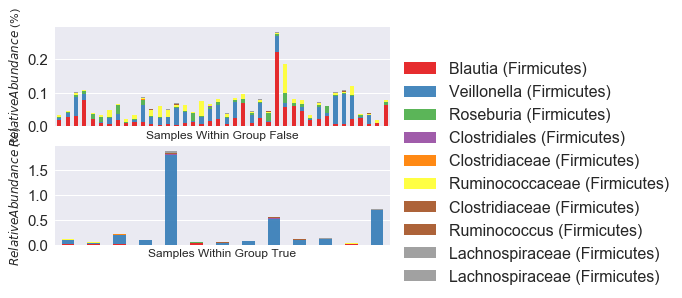

In [6]:
# get important features
n=10 #this will tell the command how many bacteria to plot
niche='Cowmilk' #this is a mapping file catagory you would like to plot
filter_names=['Unknown','Not applicable'] #this is a list of labels in the mapping you would like removed such as Unknown or Not available
# complete will determine if you do completion (iteration is the number of iterations for the completion)
sfotus,sfmappingdf=fetch.matchtable(infant_low_rank_data,mappingdf.T[~mappingdf.T[niche].isin(filter_names)].T)
important_otus=untangle.features_ml(sfotus,sfmappingdf.T,niche,complete=True,iteration=300)
#plot
fig=untangle.feature_vis(sfotus,sfmappingdf,list(important_otus.index[:n]),niche,taxnames)
plt.show()

 Here we find that the OTUs that best differentiate the samples between the infant pre and post scows milk are in the phylum Firmicutes. More specifically we see that the infant pre cows milk have a higher abundance of Alstipes compared to the infant after cowsmilk who have a higher abundance of Dorea. 


From this we can conclude that the main OTU drivers between the cowsmilk and non-cowsmilk fed the infant are from the phyla Firmicutes. Importantly, we can also see that this separation is driven by missing or reduced OTUs in the formula fed infant.

Now we can view this pattern directly in the OTU table using biclustering, first we will write a simple plotting script allowing us to compare between before and after matrix completion

In [7]:
# we will use this as our simple plotting function
def plot_compare(otudata,pcoaotu,mapping,catvis,titleadd='',hmax=6,fig_fontsize=18):
    r=2
    biploto,datatmp=untangle.biplot(otudata.copy(),r)

    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 5)) 

    if titleadd!='':
        fig.suptitle('%s '%(titleadd),fontsize=fig_fontsize+4)

    sns.heatmap(otudata,xticklabels=False, yticklabels=False,robust=True,ax=ax1)
    ax1.set_title('OTU Table\n',fontsize=fig_fontsize)    
    ax1.set_ylabel('OTUs',fontsize=fig_fontsize-2)
    ax1.set_xlabel('Samples',fontsize=fig_fontsize-2)

    sns.heatmap(biploto,xticklabels=False, yticklabels=False,robust=True,ax=ax2)
    ax2.set_title('Spectral Coclustering \n',fontsize=fig_fontsize)    
    ax2.set_ylabel('OTUs',fontsize=fig_fontsize-2)
    ax2.set_xlabel('Samples',fontsize=fig_fontsize-2)

    untangle._scatter(ax3,untangle.reduce_plot(pcoaotu,mapping,catvis,method='PCoA',reduce_only=True),catvis)
    ax3.set_title('PCoA (bray-curtis) \n',fontsize=fig_fontsize)
    ax3.set_ylabel('$PC-1$',fontsize=fig_fontsize-2)
    ax3.set_xlabel('$PC-2$',fontsize=fig_fontsize-2)    

    plt.tight_layout()
    fig.subplots_adjust(top=.78)

    return biploto

Now we will perform PCoA and biclustering for the OTU table before and after matrix completion 

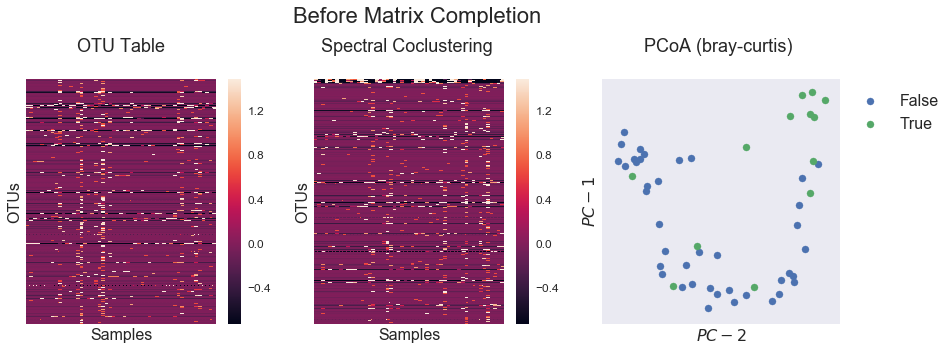

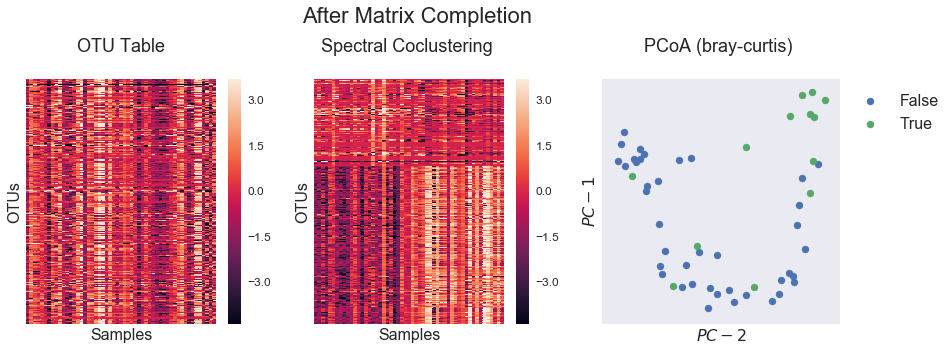

In [8]:
#take clr 
orgplotclr=pd.DataFrame(clr(otutabledf.as_matrix().copy()+1),columns=sfotus.columns,index=sfotus.index)
#plot biplot comparison 
biplotorg=plot_compare(orgplotclr,sfotus,sfmappingdf,niche,titleadd='Before Matrix Completion ')
plt.show()

#complete and take clr 
completed=pd.DataFrame(clr(untangle.complete_matrix(sfotus.as_matrix().copy(),iteration=100,minval=1e-3)),columns=sfotus.columns,index=sfotus.index)   
#plot biplots comparison 
biplotlr=plot_compare(completed,sfotus,sfmappingdf,niche,titleadd='After Matrix Completion ')
plt.show()

Finally, we can see that indeed we can sort the OTUs into the repective groups. This can be increibly power because you can start to vuew each cluster as community specfiic to different enviornments. 

Let's try to run the balances to see if the matrix completion can improve the predictive accuracy.

In [17]:
from gneiss.cluster import correlation_linkage

formula = "Age + Breastmilk + Cowmilk + Formula + Solid_food"
table = otutabledf.T
mapping = mappingdf.T
mapping = mapping.rename(columns={'Solid food': 'Solid_food'})
tree = correlation_linkage(table+1)
res_pseudo, params, cv_pseudo = optimize_impute.ols_regression(
    table+1, tree, mapping, 
    formula=formula, complete_matrix=False)

In [31]:
table.shape

(53, 2063)

In [39]:
res_complete, params, cv_complete = optimize_impute.ols_regression(
    table=table, tree=tree, metadata=mapping, 
    formula=formula, complete_matrix=True)

In [40]:
import pickle

pickle.dump(res_pseudo, open('infant_pseudo_regression_model.pickle', 'wb'))
cv_pseudo.to_csv('infant_pseudo_cv.csv')
pickle.dump(res_complete, open('infant_complete_regression_model.pickle', 'wb'))
cv_complete.to_csv('infant_complete_cv.csv')